# **Problem Statement**

X Education, an online course provider for industry professionals, faces challenges with a low lead conversion rate of 30%. The company generates leads through various channels such as website visits, form submissions, and referrals. To improve efficiency, they aim to identify "Hot Leads" — the most promising prospects likely to convert into paying customers. This requires developing a predictive model to assign a lead score to each lead, prioritizing sales efforts and achieving a target conversion rate of 80%.



#### **Importing Libraries**

In [1]:
# Core Libraries
import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation and analysis
from scipy.stats import zscore # Handle Outliers

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting graphs
import seaborn as sns  # Advanced visualizations for EDA

# Preprocessing and Feature Engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Scaling and encoding
from sklearn.feature_selection import RFE  # Recursive feature elimination for feature selection
from sklearn.decomposition import PCA  # Dimensionality reduction (if needed)

# Splitting Data
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold
) # Splitting and cross-validation

# Model Building
from sklearn.linear_model import LogisticRegression  # Logistic regression model

# Model Evaluation
from sklearn.metrics import (
    classification_report,  # Detailed performance report
    confusion_matrix,       # Confusion matrix
    roc_auc_score,          # ROC-AUC metric
    roc_curve,              # ROC curve for threshold analysis
    auc                    # Calculate AUC (Area Under Curve)
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Pipeline Management
from sklearn.pipeline import Pipeline  # Combine preprocessing and modeling in a single workflow

# Model Persistence
import joblib  # Save and load models for reproducibility


#### **Loading and Exploring Dataset**

In [2]:
leads_data = pd.read_csv('Leads.csv')

print(f'''
{leads_data.info()}
{leads_data.head(5)}
{leads_data.isnull().sum()}
''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

#### **Irelevant Columns to Drop**


In [3]:
print("Before: ", leads_data.columns)

# List of columns to drop
columns_to_drop = [
    'Prospect ID', 'Lead Number', 'Magazine', 'Newspaper Article', 'X Education Forums',
    'Newspaper', 'Update me on Supply Chain Content', 'Get updates on DM Content',
    'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview',
    'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
    'Asymmetrique Profile Score'
]
leads_data.drop(columns=columns_to_drop, axis=1, inplace=True)

print("After: ", leads_data.columns)

Before:  Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')
Af

#### **Preprocessing**

In [4]:
# To replace Select with null in categorical columns
leads_data.replace('Select', pd.NA, inplace=True)

# To calculate missing percentage in every numerical columns
missing_percentage = (leads_data.isnull().sum() / len(leads_data)) * 100

# Drop columns with more than 40% null values
columns_to_drop = missing_percentage[missing_percentage > 40].index
leads_data_cleaned = leads_data.drop(columns=columns_to_drop, axis=1)

# Display the updated dataset info and remaining missing values
updated_info = leads_data_cleaned.info()
remaining_missing = leads_data_cleaned.isnull().sum()

updated_info, remaining_missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9204 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9103 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9103 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        6779 

(None,
 Lead Origin                                         0
 Lead Source                                        36
 Do Not Email                                        0
 Do Not Call                                         0
 Converted                                           0
 TotalVisits                                       137
 Total Time Spent on Website                         0
 Page Views Per Visit                              137
 Last Activity                                     103
 Country                                          2461
 Specialization                                   3380
 What is your current occupation                  2690
 What matters most to you in choosing a course    2709
 Search                                              0
 Digital Advertisement                               0
 Through Recommendations                             0
 Receive More Updates About Our Courses              0
 Tags                                             3353
 Ci

In [5]:
# Impute missing values in numerical columns

leads_data_cleaned.fillna({
    'TotalVisits': leads_data_cleaned['TotalVisits'].median(),
    'Page Views Per Visit': leads_data_cleaned['Page Views Per Visit'].median()
}, inplace=True)

# Impute missing values in categorical columns
categorical_columns_to_impute = [
    'Lead Source',
    'Last Activity',
    'Country',
    'Specialization',
    'What is your current occupation',
    'What matters most to you in choosing a course',
    'Tags',
    'City']


leads_data_cleaned.fillna({col: 'Unknown' for col in categorical_columns_to_impute}, inplace=True)

# Verify to see if there are still columns with missing values
missing_values = leads_data_cleaned.isnull().sum().sum()
print(f"Total Missing Values: {missing_values}")

Total Missing Values: 0


#### **Handling Outliers**

In [6]:
# Separate numerical, ordinal, and nominal features for tailored outlier handling
numerical_cols = leads_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = leads_data_cleaned.select_dtypes(include=['object']).columns

In [7]:
# We do not apply Z-score removal to categorical features, so we leave them out
# Ordinal and nominal features can be included if you have specific conditions for them
# For now, we consider all categorical values valid (no outliers)

# Outlier removal for numerical columns using Z-score
z_scores = zscore(leads_data_cleaned[numerical_cols])
numerical_outliers = (abs(z_scores) < 3).all(axis=1)  # Keep rows where all numerical columns are valid


In [8]:
# Handle categorical columns
# Nominal columns: Identify columns with high cardinality
nominal_cols = [col for col in categorical_cols if leads_data_cleaned[col].nunique() > 5]

# Detect and remove rare values in nominal columns (e.g., values occurring < 1% of the time)
nominal_outliers = pd.Series(True, index=leads_data_cleaned.index)
for col in nominal_cols:
    value_counts = leads_data_cleaned[col].value_counts(normalize=True)
    rare_values = value_counts[value_counts < 0.01].index
    nominal_outliers &= ~leads_data_cleaned[col].isin(rare_values)

# Ordinal columns: Identify columns with low cardinality
ordinal_cols = [col for col in categorical_cols if leads_data_cleaned[col].nunique() <= 5]

# Handle ordinal outliers by checking if values are in the expected range
ordinal_outliers = pd.Series(True, index=leads_data_cleaned.index)
for col in ordinal_cols:
    valid_values = leads_data_cleaned[col].unique()  # Assume all observed values are valid
    ordinal_outliers &= leads_data_cleaned[col].isin(valid_values)


In [9]:
# Combine outliers: keep rows that are not outliers in any feature
combined_outliers = numerical_outliers & ordinal_outliers & nominal_outliers

# Ensure the boolean series has the same index as the DataFrame
combined_outliers = combined_outliers.reindex(leads_data_cleaned.index)

# Apply the boolean mask to filter out outliers
leads_data_cleaned_cleaned = leads_data_cleaned[combined_outliers]

# Verify the cleaned data
print(leads_data_cleaned_cleaned.head())

               Lead Origin     Lead Source Do Not Email Do Not Call  \
0                      API      Olark Chat           No          No   
1                      API  Organic Search           No          No   
2  Landing Page Submission  Direct Traffic           No          No   
3  Landing Page Submission  Direct Traffic           No          No   
4  Landing Page Submission          Google           No          No   

   Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0          0.0                            0                   0.0   
1          0          5.0                          674                   2.5   
2          1          2.0                         1532                   2.0   
3          0          1.0                          305                   1.0   
4          1          2.0                         1428                   1.0   

             Last Activity  Country           Specialization  \
0  Page Visited on Website  

### Finding suitable encoding for Logistic Regression
---

### Comparison
| **Method**              | **Pros**                                     | **Cons**                                     |
|--------------------------|---------------------------------------------|---------------------------------------------|
| **One-Hot Encoding**     | Retains all category information            | High dimensionality, potential multicollinearity |
| **Target Encoding**      | Efficient, preserves relationship with target | Prone to overfitting without proper validation |
| **Frequency Encoding**   | Simple, low dimensionality                  | Loses target-specific information           |


#### **Encoding (One Hot Encoding)**

In [10]:
'''
# Identify categorical columns for encoding
categorical_columns = leads_data_cleaned.select_dtypes(include=['object']).columns

# Exclude unique identifiers and target variable for encoding
categorical_columns = [col for col in categorical_columns if col != 'Converted']

# Perform one-hot encoding for categorical variables
encoded_features_df = pd.get_dummies(leads_data_cleaned[categorical_columns], drop_first=True)

# Drop the original categorical columns from the main data
leads_data_cleaned = leads_data_cleaned.drop(columns=categorical_columns)

# Reset index for both dataframes to ensure alignment
leads_data_cleaned = leads_data_cleaned.reset_index(drop=True)
encoded_features_df = encoded_features_df.reset_index(drop=True)

# Concatenate the non-categorical data and encoded features
leads_data_encoded = pd.concat([leads_data_cleaned, encoded_features_df], axis=1)

# Verify the updated dataset
encoded_shape = leads_data_encoded.shape
encoded_info = leads_data_encoded.info()
encoded_head = leads_data_encoded.head()

encoded_shape, encoded_info, encoded_head
'''

"\n# Identify categorical columns for encoding\ncategorical_columns = leads_data_cleaned.select_dtypes(include=['object']).columns\n\n# Exclude unique identifiers and target variable for encoding\ncategorical_columns = [col for col in categorical_columns if col != 'Converted']\n\n# Perform one-hot encoding for categorical variables\nencoded_features_df = pd.get_dummies(leads_data_cleaned[categorical_columns], drop_first=True)\n\n# Drop the original categorical columns from the main data\nleads_data_cleaned = leads_data_cleaned.drop(columns=categorical_columns)\n\n# Reset index for both dataframes to ensure alignment\nleads_data_cleaned = leads_data_cleaned.reset_index(drop=True)\nencoded_features_df = encoded_features_df.reset_index(drop=True)\n\n# Concatenate the non-categorical data and encoded features\nleads_data_encoded = pd.concat([leads_data_cleaned, encoded_features_df], axis=1)\n\n# Verify the updated dataset\nencoded_shape = leads_data_encoded.shape\nencoded_info = leads_data

#### **Encoding (Target Encoding)**

In [11]:

import numpy as np

# Identify categorical columns for encoding
categorical_columns = leads_data_cleaned.select_dtypes(include=['object', 'bool']).columns

# Exclude unique identifiers and target variable
target_variable = 'Converted'
categorical_columns = [col for col in categorical_columns if col != target_variable]

# Perform target encoding with K-Fold to avoid data leakage
kf = KFold(n_splits=5, shuffle=True, random_state=42)
encoded_features = pd.DataFrame(index=leads_data_cleaned.index)

for col in categorical_columns:
    # Temporary array to store target-encoded values
    temp_encoded = pd.Series(index=leads_data_cleaned.index, dtype=float)
    for train_idx, val_idx in kf.split(leads_data_cleaned):
        train_data, val_data = leads_data_cleaned.iloc[train_idx], leads_data_cleaned.iloc[val_idx]
        mean_target = train_data.groupby(col)[target_variable].mean()
        temp_encoded.iloc[val_idx] = val_data[col].map(mean_target)

    # Fill missing values with overall target mean
    overall_mean = leads_data_cleaned[target_variable].mean()
    encoded_features[col] = temp_encoded.fillna(overall_mean)

# Drop the original categorical columns and add the encoded features
leads_data_cleaned = leads_data_cleaned.drop(columns=categorical_columns)
leads_data_encoded = pd.concat([leads_data_cleaned, encoded_features], axis=1)

# Verify the updated dataset
encoded_shape = leads_data_encoded.shape
encoded_info = leads_data_encoded.info()
encoded_head = leads_data_encoded.head()

encoded_shape, encoded_info, encoded_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Converted                                      9240 non-null   int64  
 1   TotalVisits                                    9240 non-null   float64
 2   Total Time Spent on Website                    9240 non-null   int64  
 3   Page Views Per Visit                           9240 non-null   float64
 4   Lead Origin                                    9240 non-null   float64
 5   Lead Source                                    9240 non-null   float64
 6   Do Not Email                                   9240 non-null   float64
 7   Do Not Call                                    9240 non-null   float64
 8   Last Activity                                  9240 non-null   float64
 9   Country                                        9240 

((9240, 20),
 None,
    Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
 0          0          0.0                            0                   0.0   
 1          0          5.0                          674                   2.5   
 2          1          2.0                         1532                   2.0   
 3          0          1.0                          305                   1.0   
 4          1          2.0                         1428                   1.0   
 
    Lead Origin  Lead Source  Do Not Email  Do Not Call  Last Activity  \
 0     0.311892     0.252284      0.400323     0.381326       0.247544   
 1     0.312762     0.374062      0.408254     0.387686       0.366740   
 2     0.363847     0.323734      0.408254     0.387686       0.366740   
 3     0.362632     0.325593      0.404146     0.385604       0.342105   
 4     0.363847     0.402992      0.408254     0.387686       0.114370   
 
     Country  Specialization  What is your cur

#### **Encoding (Frequency Encoding)**

In [12]:
'''
# Perform frequency encoding
encoded_features = pd.DataFrame(index=leads_data_cleaned.index)
for col in categorical_columns:
    freq_map = leads_data_cleaned[col].value_counts(normalize=True)
    encoded_features[col] = leads_data_cleaned[col].map(freq_map)

# Drop original categorical columns and add encoded features
leads_data_cleaned = leads_data_cleaned.drop(columns=categorical_columns)
leads_data_encoded = pd.concat([leads_data_cleaned, encoded_features], axis=1)

# Verify the updated dataset
encoded_shape = leads_data_encoded.shape
encoded_info = leads_data_encoded.info()
encoded_head = leads_data_encoded.head()

encoded_shape, encoded_info, encoded_head
leads_data_encoded.shape
'''

'\n# Perform frequency encoding\nencoded_features = pd.DataFrame(index=leads_data_cleaned.index)\nfor col in categorical_columns:\n    freq_map = leads_data_cleaned[col].value_counts(normalize=True)\n    encoded_features[col] = leads_data_cleaned[col].map(freq_map)\n\n# Drop original categorical columns and add encoded features\nleads_data_cleaned = leads_data_cleaned.drop(columns=categorical_columns)\nleads_data_encoded = pd.concat([leads_data_cleaned, encoded_features], axis=1)\n\n# Verify the updated dataset\nencoded_shape = leads_data_encoded.shape\nencoded_info = leads_data_encoded.info()\nencoded_head = leads_data_encoded.head()\n\nencoded_shape, encoded_info, encoded_head\nleads_data_encoded.shape\n'

#### **Inspect Feature Changes**

In [13]:
# To check feature ranges and see if scaling is needed
feature_ranges = leads_data_encoded.describe().T[['min', 'max']]
print(feature_ranges)

# Criteria: if the ratio between mac and min values > 10.1, scaling is required
for feature, row in feature_ranges.iterrows():
  max_min_ratio = row['max'] / max(1, abs(row['min']))
  if max_min_ratio > 10:
    print(f"Scaling required for feature: {feature}, Ratio: {max_min_ratio:.2f}")
  else:
    print(f"Scaling not required for feature: {feature}")

                                                    min          max
Converted                                      0.000000     1.000000
TotalVisits                                    0.000000   251.000000
Total Time Spent on Website                    0.000000  2272.000000
Page Views Per Visit                           0.000000    55.000000
Lead Origin                                    0.220000     0.932759
Lead Source                                    0.000000     1.000000
Do Not Email                                   0.152249     0.408254
Do Not Call                                    0.381326     1.000000
Last Activity                                  0.000000     1.000000
Country                                        0.000000     1.000000
Specialization                                 0.181818     0.521368
What is your current occupation                0.135900     1.000000
What matters most to you in choosing a course  0.000000     1.000000
Search                            

#### **Applying Scaling**



In [14]:
# Using StandardScaler (StandardScaler/MinMaxScaler)
# StandardScaler is better choice for linear regression

scaler = StandardScaler()

numerical_features = leads_data_encoded.select_dtypes(include=['float', 'int64']).columns

# Scaling
leads_data_encoded[numerical_features] = scaler.fit_transform(leads_data_encoded[numerical_features])

print(leads_data_encoded.describe().T[['mean', 'std']])

                                                       mean       std
Converted                                      2.306957e-17  1.000054
TotalVisits                                    3.998725e-17  1.000054
Total Time Spent on Website                    2.499203e-17  1.000054
Page Views Per Visit                          -8.997132e-17  1.000054
Lead Origin                                   -1.507212e-16  1.000054
Lead Source                                    1.661009e-16  1.000054
Do Not Email                                   8.781816e-16  1.000054
Do Not Call                                    8.688000e-15  1.000054
Last Activity                                 -2.733744e-16  1.000054
Country                                       -6.874732e-16  1.000054
Specialization                                -7.882103e-18  1.000054
What is your current occupation               -4.064089e-16  1.000054
What matters most to you in choosing a course -1.268826e-16  1.000054
Search              

#### **Correlation Analysis**

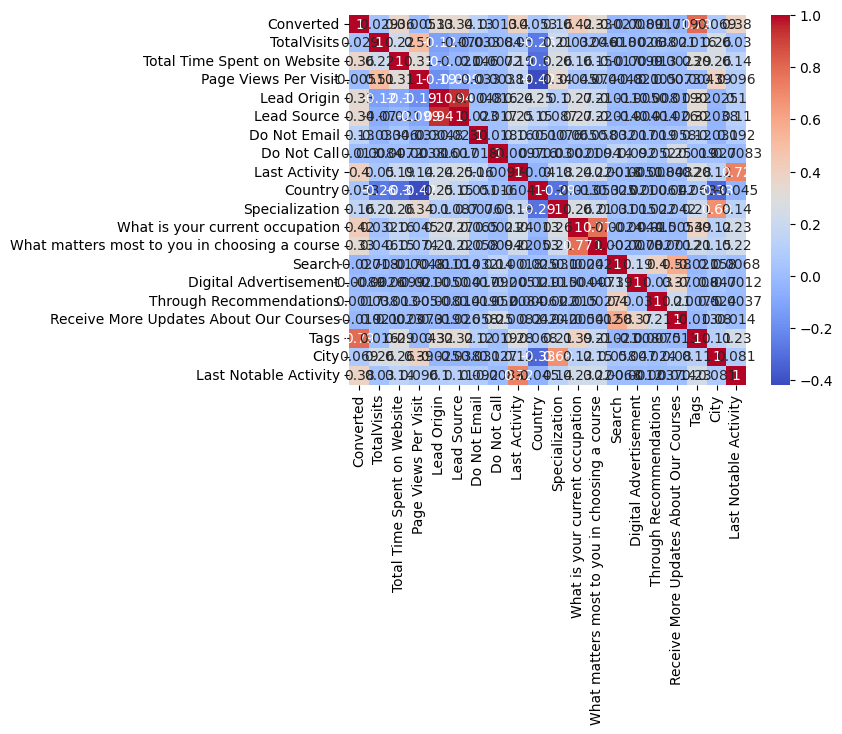

In [15]:
# non_numeric_columns = leads_data_encoded.select_dtypes(exclude=['number']).columns
# print(non_numeric_columns)

leads_data_numeric = leads_data_encoded.select_dtypes(include=['number'])

corr_matrix = leads_data_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [16]:
# We are removing scaling as it drops too many columns, leaving not enough columns for modeling
'''
# Shape before removing columns
print("Dataset Shape Before the Operation: ", leads_data_encoded.shape)

# Calculate the correlation matrix for numeric columns
leads_data_numeric = leads_data_encoded.select_dtypes(include=['number'])
corr_matrix = leads_data_numeric.corr()

# Drop highly correlated features (threshold > 0.85)
highly_corr_features = [
    col for col in corr_matrix.columns
    if any(corr_matrix[col].abs() > 0.85) and col != 'Converted'
]
print(f"Highly correlated features: {highly_corr_features}")
leads_data_encoded = leads_data_encoded.drop(columns=highly_corr_features, errors='ignore')

# Drop least correlated features (threshold < 0.1)
least_corr_features = [
    col for col in corr_matrix.columns
    if abs(corr_matrix['Converted'][col]) < 0.3 and col != 'Converted'
]
print(f"Least correlated features: {least_corr_features}")
leads_data_encoded = leads_data_encoded.drop(columns=least_corr_features, errors='ignore')

# Shape after removing columns
print("Dataset Shape After the Operation: ", leads_data_encoded.shape)
'''

'\n# Shape before removing columns\nprint("Dataset Shape Before the Operation: ", leads_data_encoded.shape)\n\n# Calculate the correlation matrix for numeric columns\nleads_data_numeric = leads_data_encoded.select_dtypes(include=[\'number\'])\ncorr_matrix = leads_data_numeric.corr()\n\n# Drop highly correlated features (threshold > 0.85)\nhighly_corr_features = [\n    col for col in corr_matrix.columns\n    if any(corr_matrix[col].abs() > 0.85) and col != \'Converted\'\n]\nprint(f"Highly correlated features: {highly_corr_features}")\nleads_data_encoded = leads_data_encoded.drop(columns=highly_corr_features, errors=\'ignore\')\n\n# Drop least correlated features (threshold < 0.1)\nleast_corr_features = [\n    col for col in corr_matrix.columns\n    if abs(corr_matrix[\'Converted\'][col]) < 0.3 and col != \'Converted\'\n]\nprint(f"Least correlated features: {least_corr_features}")\nleads_data_encoded = leads_data_encoded.drop(columns=least_corr_features, errors=\'ignore\')\n\n# Shape aft

#### **Splitting Data**

In [17]:
# Separate features and target

print("Dataset Shape:", leads_data_encoded.shape)

X = leads_data_encoded.drop(columns=['Converted'])
y = leads_data_encoded['Converted']

print("X: ", X.shape)
print("Y: ", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train: ", X_train.shape)
print("Y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", y_test.shape)


assert X.select_dtypes(include=['object']).empty, "X contains non-numeric data!"

# Verify the split
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Dataset Shape: (9240, 20)
X:  (9240, 19)
Y:  (9240,)
X_train:  (7392, 19)
Y_train:  (7392,)
X_test:  (1848, 19)
Y_test:  (1848,)
Training set size: (7392, 19), Test set size: (1848, 19)


#### **Checking Datatypes**

In [18]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train dtypes:", X_train.dtypes)
print("y_train dtypes:", y_train.dtypes)


X_train shape: (7392, 19)
y_train shape: (7392,)
X_train dtypes: TotalVisits                                      float64
Total Time Spent on Website                      float64
Page Views Per Visit                             float64
Lead Origin                                      float64
Lead Source                                      float64
Do Not Email                                     float64
Do Not Call                                      float64
Last Activity                                    float64
Country                                          float64
Specialization                                   float64
What is your current occupation                  float64
What matters most to you in choosing a course    float64
Search                                           float64
Digital Advertisement                            float64
Through Recommendations                          float64
Receive More Updates About Our Courses           float64
Tags                   

#### **Building the Model**

In [19]:
# If y_train is supposed to be a classification target, convert it to integer type
y_train = y_train.astype(int)

# Initialize the logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### **Correlation Analysis**

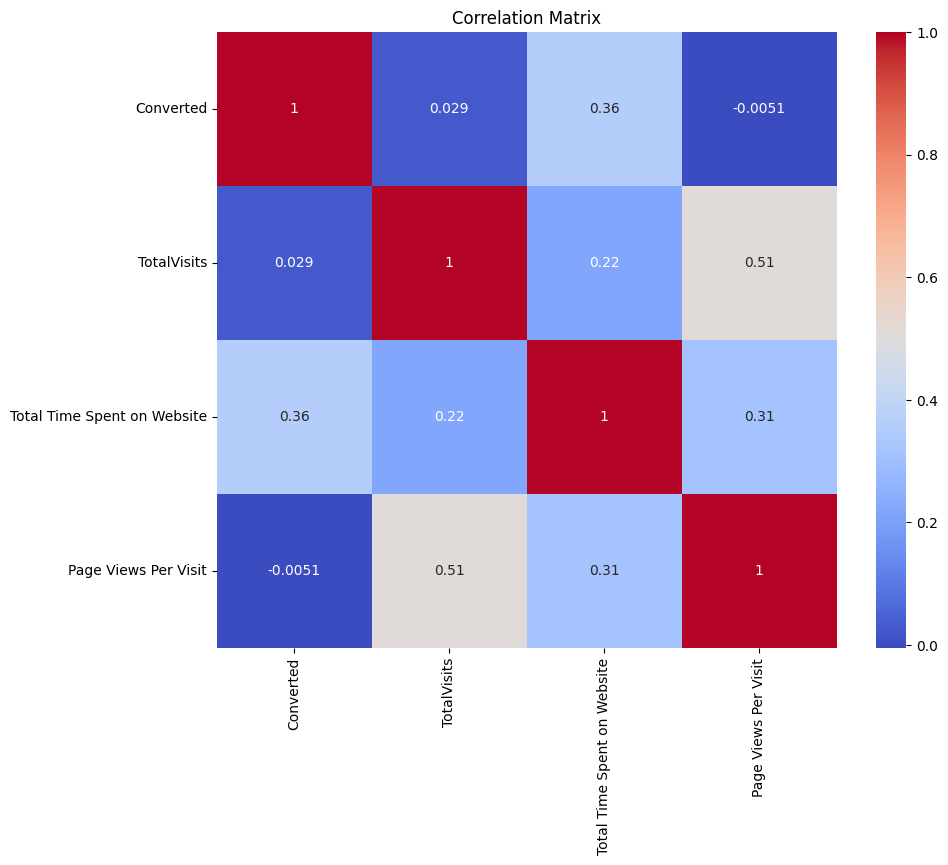

In [20]:
# Compute correlation matrix
correlation_matrix = leads_data_cleaned.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### **RFE**

In [21]:
# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected Features by RFE:\n", selected_features)

Selected Features by RFE:
 Index(['Total Time Spent on Website', 'Page Views Per Visit', 'Lead Source',
       'Do Not Email', 'Last Activity', 'Country',
       'What matters most to you in choosing a course', 'Tags', 'City',
       'Last Notable Activity'],
      dtype='object')


#### **PCA**

In [22]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by PCA:\n", explained_variance)

Explained Variance by PCA:
 [0.17522683 0.14171438 0.08174057 0.07521575 0.06663799 0.06450031
 0.06043356 0.05270511 0.05152469 0.04682415]


#### **Prediction**

In [23]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

#### **Evaluating the Model**

In [24]:
y_test = y_test.astype(int)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1107
           1       0.92      0.86      0.89       741

    accuracy                           0.91      1848
   macro avg       0.91      0.90      0.91      1848
weighted avg       0.91      0.91      0.91      1848

Confusion Matrix:
 [[1048   59]
 [ 104  637]]
ROC-AUC Score: 0.9719726144629868


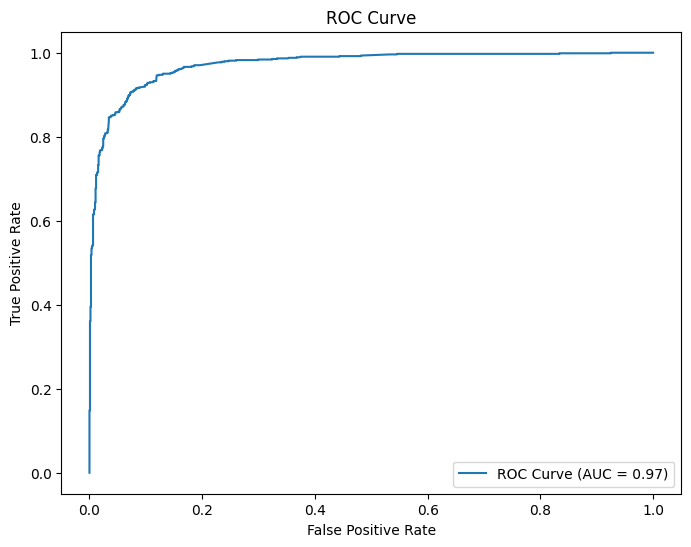

In [25]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


#### **Residual Analysis**

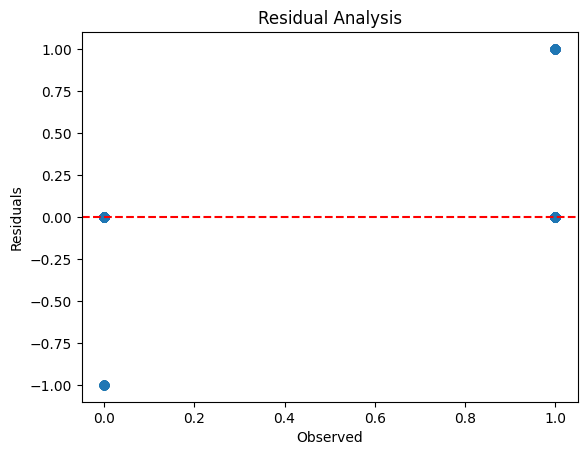

In [26]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Observed")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()

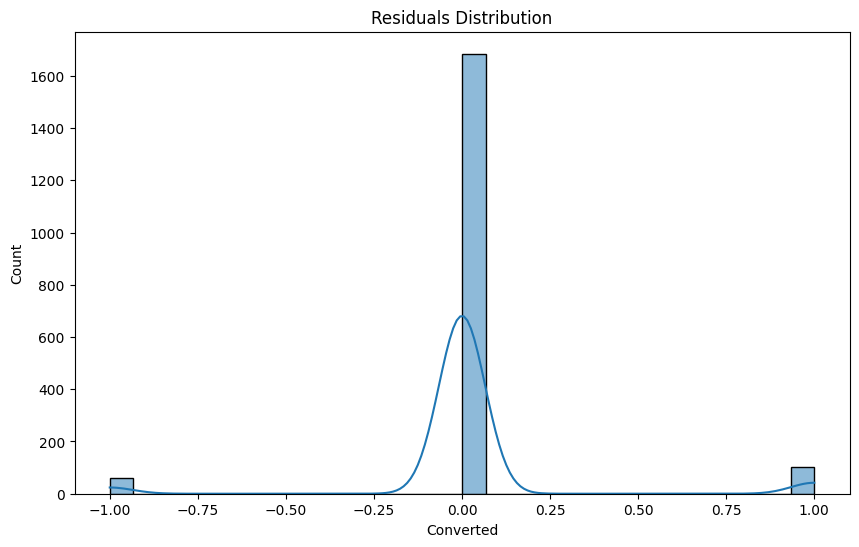

In [27]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.show()

#### **Feature Importance**

In [28]:
# Extract feature names and coefficients
feature_names = X_train.columns
coefficients = model.coef_[0]

# Combine and rank features by importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Display top features
print("Top Features:\n", feature_importance.head(10))

Top Features:
                                           Feature  Coefficient
16                                           Tags     2.759021
1                     Total Time Spent on Website     0.933754
18                          Last Notable Activity     0.738104
7                                   Last Activity     0.439801
11  What matters most to you in choosing a course     0.306004
8                                         Country     0.223226
5                                    Do Not Email     0.208278
4                                     Lead Source     0.188717
3                                     Lead Origin     0.169046
0                                     TotalVisits     0.150408


#### **Final Quality Check**

In [29]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.9117965367965368
Precision: 0.9152298850574713
Recall: 0.8596491228070176
F1-Score: 0.8865692414752957


In [31]:
# Extracting True Negative, False Positive, False Negative, True Positive
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Saving value of True Positive in converted_leads
converted_leads = tp

# Saving sum of y_pred in total_predicted_hot_leads
total_predicted_hot_leads = sum(y_pred)

achieved_conversion_rate = (converted_leads / total_predicted_hot_leads) * 100

print(f"Total Conversion Rate: {achieved_conversion_rate}")

Total Conversion Rate: 91.52298850574712


#### **Pipeline**

In [32]:
# Pipeline Management
pipeline = Pipeline([
    ('pca', PCA(n_components=10)),
    ('logistic', LogisticRegression(random_state=42, max_iter=1000))
])
pipeline.fit(X_train, y_train)
print("Pipeline Model Score:", pipeline.score(X_test, y_test))

Pipeline Model Score: 0.8966450216450217


#### **Saving the Model**

In [33]:
joblib.dump(model, 'final_model.pkl')
joblib.dump({
    'categorical_columns': categorical_columns,
    'encoded_columns': leads_data_encoded.columns.tolist()
}, 'encoder_info.pkl')

['encoder_info.pkl']